In [ ]:
import numpy as np

import tensorflow as tf

!pip install -q tensorflow-hub
!pip install -q tfds-nightly
import tensorflow_hub as huba
import tensorflow_datasets as tfds

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("허브 버전: ", hub.__version__)
print("GPU", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

     |████████████████████████████████| 3.7MB 4.6MB/s 
버전:  2.3.0
즉시 실행 모드:  True
허브 버전:  0.10.0
GPU 사용 가능


# 1. 데이터 불러오기

In [10]:
from google.colab import files
files.upload()

Saving mbti_1.csv to mbti_1.csv


In [13]:
import pandas as pd
data = pd.read_csv("mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


# 2. 데이터 탐색

### - 50개의 문장 split

In [16]:
[p.split('|||') for p in data.head(1).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

### - mbti 비율확인

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


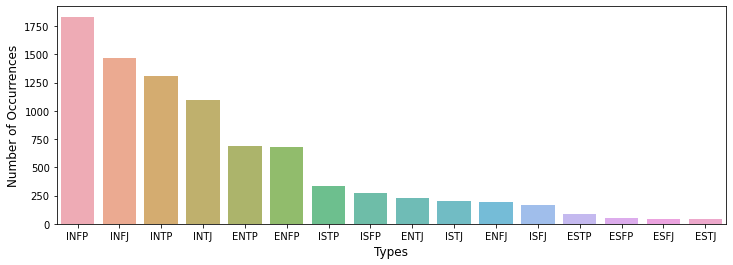

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

## 4개의 클래스로 나누기

0:'I', 1:'E'

0:'N', 1:'S'

0:'F', 1:'T'

0:'J', 1:'P'

In [51]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]


#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [26]:
data['I-E'] = list_personality_bin[:,0]
data['N-S'] = list_personality_bin[:,1]
data['F-T'] = list_personality_bin[:,2]
data['J-P'] = list_personality_bin[:,3]

In [31]:
data.head()

,type,posts,I-E,N-S,F-T,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0


# 3. 데이터 전처리

In [90]:
data['posts'].head()

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: posts, dtype: object

## train, test set 나누기

비율같게

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data[['type']]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

##### trainset 비율

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


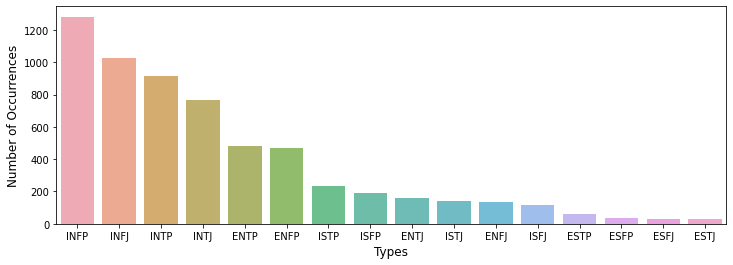

In [33]:
cnt_train = strat_train_set['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_train.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

##### testset 비율

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


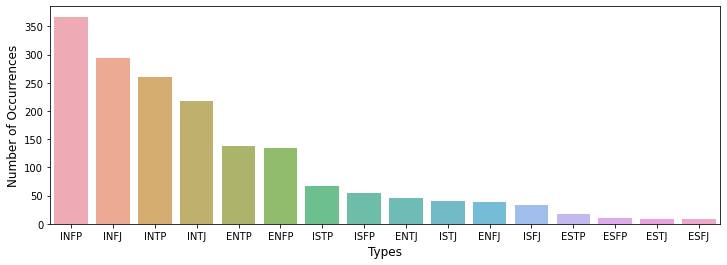

In [34]:
cnt_test = strat_test_set['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_test.index, cnt_test.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

#### 임베딩

In [35]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [42]:
#hub_layer(data['posts'])

<tf.Tensor: shape=(8675, 20), dtype=float32, numpy=
array([[  3.684846 ,  -5.055053 ,   4.405276 , ...,  -3.902714 ,
         -6.111266 ,  -3.3841834],
       [  6.2076325, -11.672959 ,   7.9199433, ...,  -4.856705 ,
         -7.3233204,  -6.3539295],
       [  6.2623024,  -8.849396 ,  10.640565 , ...,  -4.1177707,
         -6.8809347,  -5.545805 ],
       ...,
       [  5.9452734,  -9.22237  ,   8.921818 , ...,  -4.936481 ,
         -7.993247 ,  -5.8236475],
       [  7.891737 , -15.547381 ,  12.733404 , ...,  -7.604376 ,
         -9.429369 ,  -8.585928 ],
       [  7.1515565, -13.773193 ,  12.173988 , ...,  -6.6455054,
        -10.122521 ,  -7.4058466]], dtype=float32)>

## 모델1

In [39]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(4)) #4개의 클래스 분류

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 400,424
Trainable params: 400,424
Non-trainable params: 0
_________________________________________________________________


#### 손실함수와 옵티마이저

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 레이블 벡터 변환

In [60]:
train_labels = np.array([translate_personality(p) for p in strat_train_set.type])
train_labels

array([[0, 0, 0, 1],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       ...,
       [1, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 0, 1, 1]])

In [61]:
test_labels = np.array([translate_personality(p) for p in strat_test_set.type])
test_labels

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [1, 0, 1, 1],
       [0, 0, 0, 0],
       [1, 0, 1, 0]])

In [43]:
train_posts = strat_train_set['posts']
test_posts = strat_test_set['posts']

In [63]:
history = model.fit(train_posts,train_labels,
                    epochs=20,
                    batch_size=512)

Epoch 1/20
14/14 [==============================] - 2s 148ms/step - loss: 1.2638 - accuracy: 0.2138
Epoch 2/20
14/14 [==============================] - 2s 149ms/step - loss: 0.7418 - accuracy: 0.2330
Epoch 3/20
14/14 [==============================] - 2s 148ms/step - loss: 0.6497 - accuracy: 0.2775
Epoch 4/20
14/14 [==============================] - 2s 146ms/step - loss: 0.6271 - accuracy: 0.2409
Epoch 5/20
14/14 [==============================] - 2s 147ms/step - loss: 0.6182 - accuracy: 0.2427
Epoch 6/20
14/14 [==============================] - 2s 150ms/step - loss: 0.6106 - accuracy: 0.2435
Epoch 7/20
14/14 [==============================] - 2s 150ms/step - loss: 0.6048 - accuracy: 0.2481
Epoch 8/20
14/14 [==============================] - 2s 151ms/step - loss: 0.5996 - accuracy: 0.2445
Epoch 9/20
14/14 [==============================] - 2s 150ms/step - loss: 0.5947 - accuracy: 0.2458
Epoch 10/20
14/14 [==============================] - 2s 151ms/step - loss: 0.5901 - accuracy: 0.2473

In [72]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

acc = history.history['accuracy']
#val_acc = history.history['val_acc']

In [68]:
loss

[1.2637914419174194,
 0.7418444156646729,
 0.6497061848640442,
 0.6270870566368103,
 0.6182131767272949,
 0.6106371879577637,
 0.6047908663749695,
 0.599567711353302,
 0.5946827530860901,
 0.5901279449462891,
 0.5860687494277954,
 0.5820990800857544,
 0.57851642370224,
 0.5753902792930603,
 0.5726346373558044,
 0.570056140422821,
 0.5680121779441833,
 0.5656582713127136,
 0.5633764863014221,
 0.561318576335907]

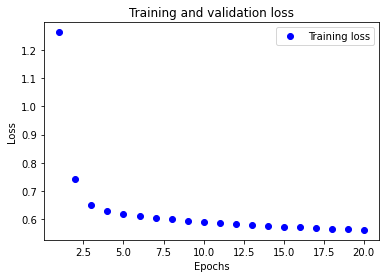

In [70]:
import matplotlib.pyplot as plt

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

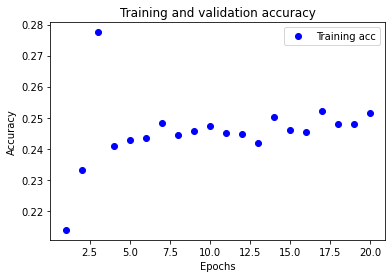

In [75]:
plt.clf() #그래프를 초기화합니다.

acc = history.history['accuracy']
#val_acc = history.history['val_accaccuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 검증

In [69]:
results = model.evaluate(test_posts, test_labels)
results

55/55 [==============================] - 1s 11ms/step - loss: 0.5706 - accuracy: 0.2582


[0.5706374645233154, 0.25821325182914734]

## 모델2

In [85]:
from keras import models
from keras import layers

model_2 = models.Sequential()
model_2.add(hub_layer)  #임베딩
#model_2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(4, activation='softmax'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 401,624
Trainable params: 401,624
Non-trainable params: 0
_________________________________________________________________


In [86]:
model_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
history = model_2.fit(train_posts,train_labels,
                    epochs=20,
                    batch_size=512)

Epoch 1/20
14/14 [==============================] - 2s 150ms/step - loss: 3.4698 - accuracy: 0.2431
Epoch 2/20
14/14 [==============================] - 2s 150ms/step - loss: 3.0987 - accuracy: 0.2429
Epoch 3/20
14/14 [==============================] - 2s 151ms/step - loss: 2.9782 - accuracy: 0.2398
Epoch 4/20
14/14 [==============================] - 2s 149ms/step - loss: 2.8543 - accuracy: 0.2569
Epoch 5/20
14/14 [==============================] - 2s 151ms/step - loss: 2.6175 - accuracy: 0.2576
Epoch 6/20
14/14 [==============================] - 2s 151ms/step - loss: 2.3188 - accuracy: 0.2571
Epoch 7/20
14/14 [==============================] - 2s 150ms/step - loss: 2.1676 - accuracy: 0.2669
Epoch 8/20
14/14 [==============================] - 2s 151ms/step - loss: 2.2111 - accuracy: 0.2579
Epoch 9/20
14/14 [==============================] - 2s 148ms/step - loss: 2.2128 - accuracy: 0.2768
Epoch 10/20
14/14 [==============================] - 2s 148ms/step - loss: 2.2507 - accuracy: 0.2732

In [88]:
results = model_2.evaluate(test_posts, test_labels)
results

55/55 [==============================] - 1s 11ms/step - loss: 4.3951 - accuracy: 0.2167


[4.395118236541748, 0.21671469509601593]